In [9]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
with sqlite3.connect('../../datasets/dev-bio_dataset.db') as dev_conn:
    developers_frame = pd.read_sql_query('SELECT BIO FROM developer_bio', dev_conn)
developers_frame

,BIO
0,I am a Senior Cybersecurity/Information Securi...
1,"I’m a Salesforce Certified Sales Cloud, Servic..."
2,"Hi, I'm Rizwan, a dedicated Data Scientist wit..."
3,I offer assistance in a range of web developme...
4,✅ 16+ Years of WordPress Experience. \n✅ 5+ Ye...
...,...
443,With 8+ years of experience working in Upwork ...
444,✅ 𝟭𝟱+ 𝘆𝗲𝗮𝗿𝘀 𝗲𝘅𝗽𝗲𝗿𝗶𝗲𝗻𝗰𝗲𝗱 𝗠𝗶𝗰𝗿𝗼𝘀𝗼𝗳𝘁 𝗔𝘇𝘂𝗿𝗲 | 𝗢𝗳𝗳𝗶...
445,Welcome to the nexus of modern software develo...
446,"With a remarkable 25-year career, I'm a season..."


In [11]:
from string import punctuation
with sqlite3.connect('../../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)

In [12]:
def remove_symbols(description: str, remove_map: dict) -> str:
    """
    """
    for old, new in remove_map.items():
        description = description.replace(old, new)
    return description.lower()


def extract_symbols(description: str, available_symbols: list) -> set:
    s = set()
    prev = ''
    for word in description.split():
        if word in available_symbols:
            s.add(word)
        elif f'{prev} {word}' in available_symbols:
            s.add(f'{prev} {word}')  
        prev = word
    return s 

def translate_skills(skills: set, toId = False) -> set:
    if toId:
        return skill_to_id(skills)
    else:
        return id_to_skill(skills)

def id_to_skill(skills: set[int]) -> set[str]:
    out = set()
    for skill in skills:
        out.add(skills_frame.loc[skill, 'SKILL'])
    
    return out

def skill_to_id(skills: set[str]) -> set[int]:
    out = set()
    for skill in skills:
        out.add(
            list(
                skills_frame.loc[
                    skills_frame['SKILL'].apply(lambda val: val.lower()) == skill.lower()
                ].index
            )[0]
        )
    
    return out

# Symbols to remove
punct = [p for p in punctuation]
punct.remove('+')
punct.remove('#')
# punct.remove('.')

removal = {p: ' ' for p in punct}
removal['\n'] = ''
removal['/'] = ' '
removal['('] = ' '
removal[')'] = ' '
removal[','] = ' '
removal['>'] = ' '
removal['.'] = ' .'

In [13]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]

# Extract skills from descriptions and add new column
required_skills = [] 
for i, offer_description in enumerate(developers_frame.loc[:, 'BIO']):
    desc = remove_symbols(offer_description, removal)
    offer_skills = extract_symbols(desc, skills_list)
    required_skills.append(translate_skills(offer_skills, toId=True))

448

In [16]:
from collections import Counter
out = []
skill_counts = Counter()
for skill_set in required_skills:
    if skill_set:
        sset = id_to_skill(skill_set)
        out.append(sset)
        for s in sset:
            skill_counts[s] += 1
sorted_counts = {skill: skill_counts[skill] for skill in sorted(skill_counts, key=skill_counts.get, reverse=True)}
len(out)

301

C:\Users\anton\AppData\Local\Temp\ipykernel_46744\642667107.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette="viridis")


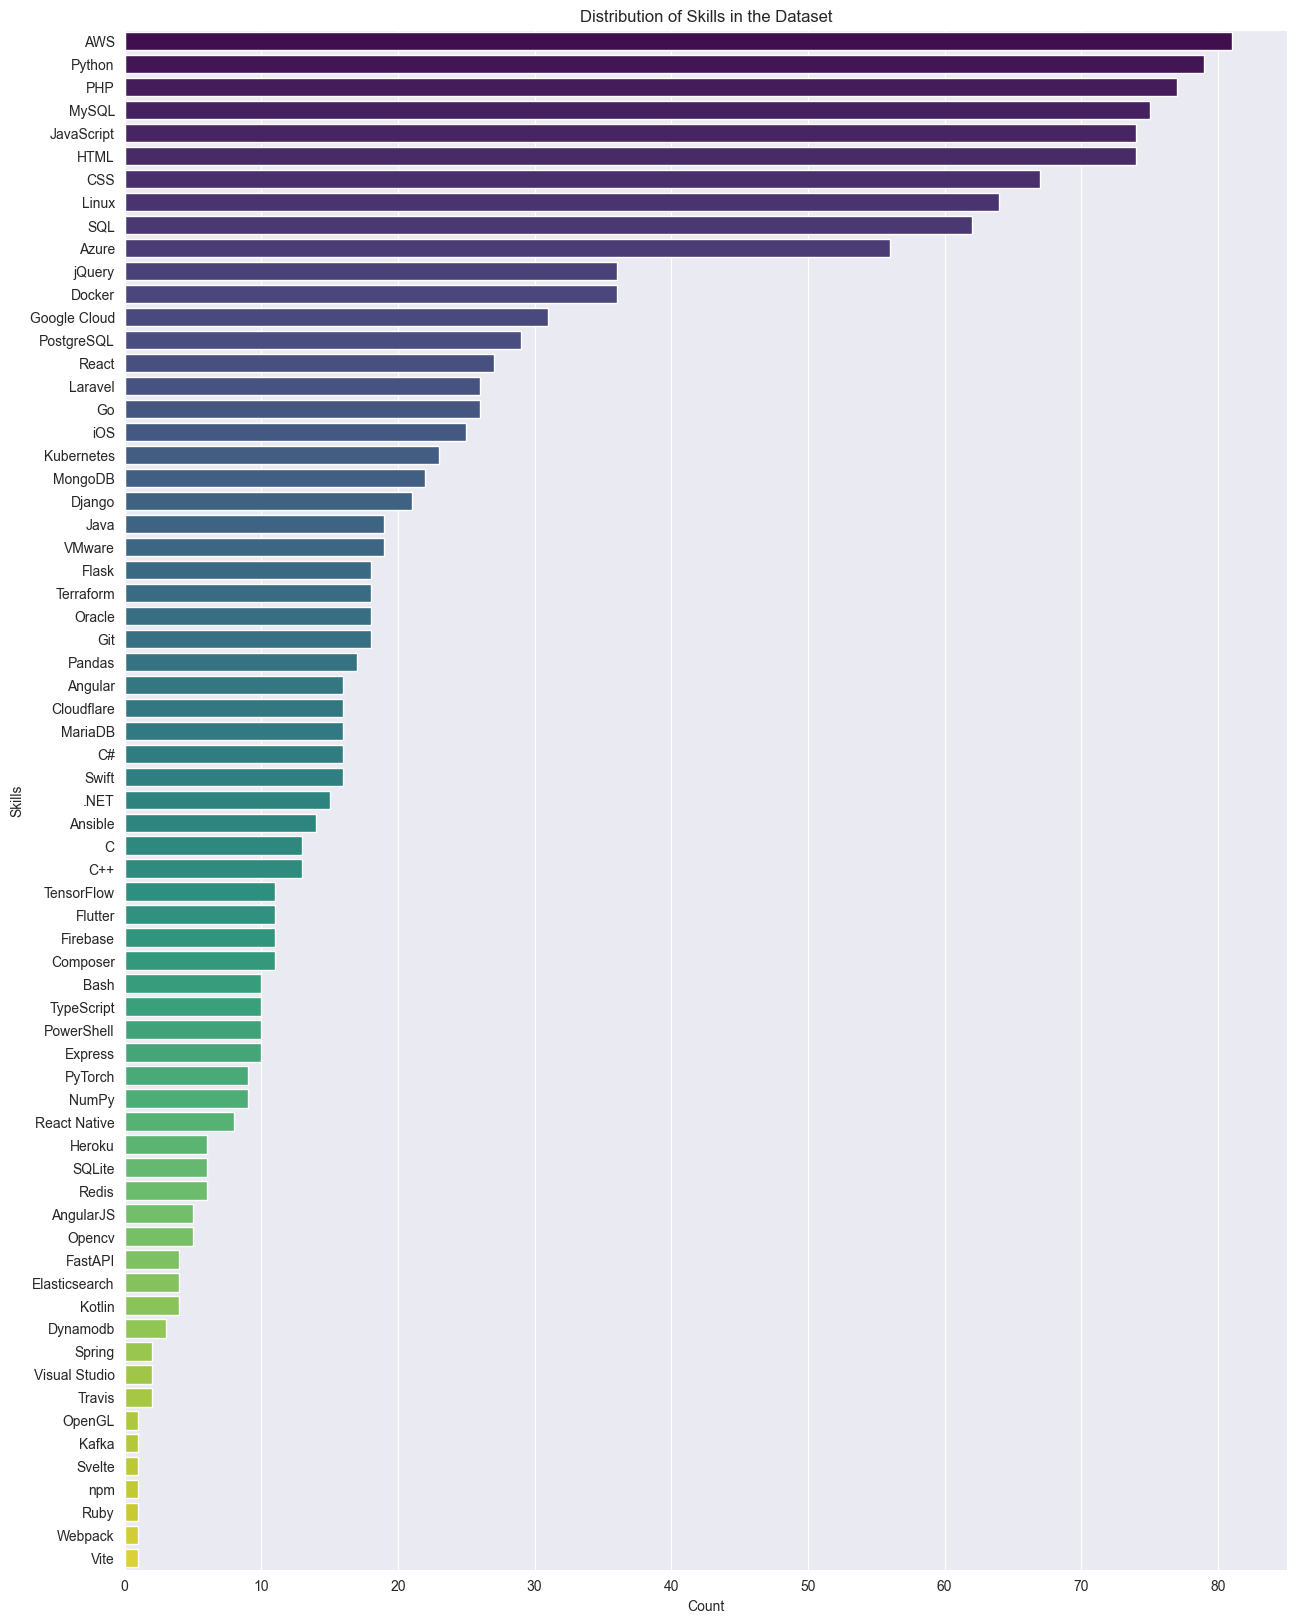

In [15]:
plt.figure(figsize=(15, 20))
sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys(), palette="viridis")
plt.title("Distribution of Skills in the Dataset")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()